In [1]:
import tensorflow as tf
gpus=tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [2]:
# Bringing in tensorflow datasets for fashion mnist
import tensorflow_datasets as tfds
# Bringing in matplotlib for Viz things
from matplotlib import pyplot as plt

In [4]:
# using the tensorflow dataset api to load in the data source  
ds=tfds.load("fashion_mnist",split="train")

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling C:\Users\ZBOOK 15 G3\tensorflow_datasets\fashion_mnist\3.0.1.incomplete4DNKPQ\fashion_mnist-train.tf…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling C:\Users\ZBOOK 15 G3\tensorflow_datasets\fashion_mnist\3.0.1.incomplete4DNKPQ\fashion_mnist-test.tfr…

Dataset fashion_mnist downloaded and prepared to C:\Users\ZBOOK 15 G3\tensorflow_datasets\fashion_mnist\3.0.1. Subsequent calls will reuse this data.


In [5]:
ds

<_PrefetchDataset element_spec={'image': TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>

In [9]:
ds.as_numpy_iterator().next().keys()

dict_keys(['image', 'label'])

In [26]:
# doing some data transformation
import numpy as np

In [18]:
# setting up data iterator
data_iterator=ds.as_numpy_iterator()

In [23]:
# getting data from the input pipeline
data_iterator.next()

{'image': array([[[  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [134],
         [171],
         [132],
         [138],
         [137],
         [129],
         [130],
         [168],
         [153],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0]],
 
        [[  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [241],
         [243],
         [226],
         [224],
         [227],
         [230],
         [237],
         [240],
         [246],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0]],
 
        [[  0],
         [  0],
         [  0],
         [  0],
         [  0],
         

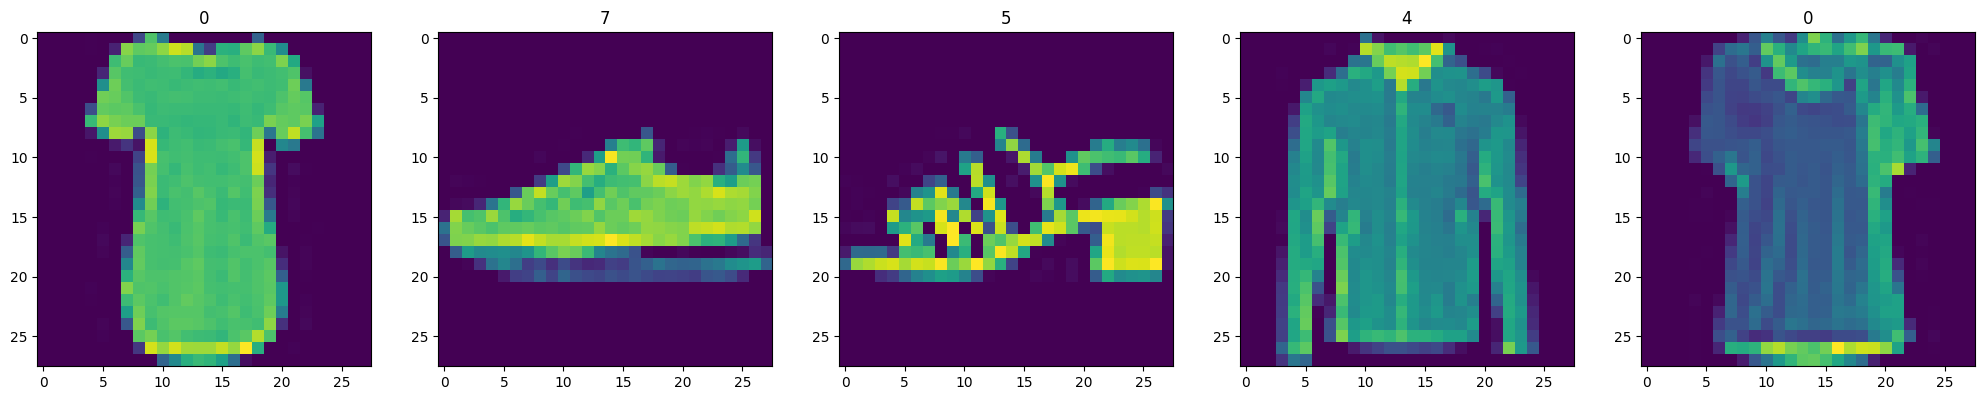

In [29]:
fig, ax=plt.subplots(ncols=5, figsize=(25,25))
for dx in range(5):
    sample=data_iterator.next()
    ax[dx].imshow(np.squeeze(sample['image']))
    ax[dx].title.set_text(sample['label'])